In [1]:
import numpy as np
import pandas as pd
import datetime as datetime

stock_data = pd.read_csv('df2330_12to22.csv')

stock_data['trend'] = np.where(stock_data.Close.shift(-5) > stock_data.Close, 1, 0)
print(stock_data.isnull().sum())

print(stock_data)


Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
trend     0
dtype: int64
            Date   Open   High    Low  Close     Volume  trend
0     2012-01-02   75.0   75.4   74.7   75.0  14945.219      1
1     2012-01-03   75.5   75.9   75.2   75.7  21223.640      1
2     2012-01-04   76.1   76.1   75.5   75.8  34126.472      1
3     2012-01-05   76.0   76.0   75.3   76.0  28076.670      1
4     2012-01-06   75.9   75.9   74.9   75.6  30123.118      1
...          ...    ...    ...    ...    ...        ...    ...
1962  2019-12-25  332.0  334.5  331.0  333.0  12262.954      0
1963  2019-12-26  333.0  334.0  331.5  333.0  11427.884      0
1964  2019-12-27  335.0  338.0  335.0  338.0  16677.806      0
1965  2019-12-30  338.0  339.0  334.0  334.5  21591.263      0
1966  2019-12-31  331.0  333.5  331.0  331.0  22950.517      0

[1967 rows x 7 columns]


In [4]:
import math
from sklearn.preprocessing import MinMaxScaler 

close_prices = stock_data['Close']
values = close_prices.values
training_data_len = math.ceil(len(values)* 0.8)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))
train_data = scaled_data[0: training_data_len, :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [5]:
test_data = scaled_data[training_data_len-60: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [7]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 25)                2525      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________


In [8]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 1, epochs=3)

Epoch 1/3
1514/1514 [==============================] - 18s 10ms/step - loss: 9.4164e-04
Epoch 2/3
1514/1514 [==============================] - 16s 10ms/step - loss: 4.2829e-04
Epoch 3/3
1514/1514 [==============================] - 16s 11ms/step - loss: 3.0916e-04


In [9]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

13/13 [==============================] - 1s 13ms/step


2.200911970842279

C:\Users\mikai\AppData\Local\Temp\ipykernel_1804\978276774.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


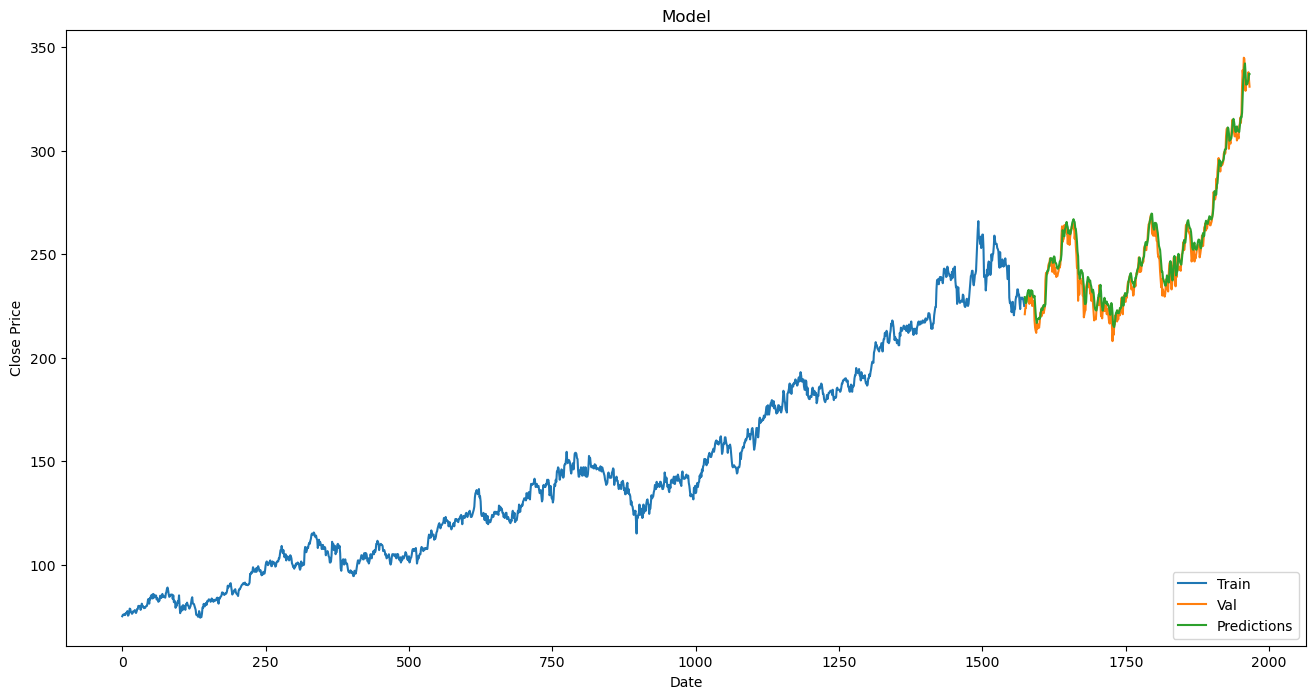

In [11]:
data = stock_data.filter(['Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()